In [135]:
from load_data import *
from solver import *
from synthetic_graphs import plot_graph, signal_smoothness_on_graph, create_graph_from_laplacian
import os,sys
sys.path.append(os.path.realpath('FGW distance on graph/lib'))
from graph import Graph
from ot_distances import Fused_Gromov_Wasserstein_distance

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load data, test functions and create graph

In [99]:
# Load data and desired columns
fuel_data = Fuel_data('../__data/Donnees-annuelles-de-consommation-de-produits-petroliers-par-departement-France-metropol.2022-09.csv')
print("num fuel", fuel_data.num_fuel)
print("num dpt", fuel_data.num_dpt)
print("num years", fuel_data.num_years)


num fuel 12
num dpt 94
num years 17


In [108]:
#Test sample one year
samples_2005, fuels = fuel_data.samples_one_year(2005)
print('samples', type(samples_2005))
print(samples_2005.shape)
print(fuels)
# check normalization
print('means (close to 0) :', [np.sum(samples_2005[:, i]) / samples_2005.shape[0] for i in range(samples_2005.shape[1])])
print('std (close to 1) :', [np.sum(samples_2005[:, i] ** 2) / samples_2005.shape[0] for i in range(samples_2005.shape[1])])

samples <class 'numpy.ndarray'>
(94, 12)
['SUPER_PLOMBE', 'SUPER_SANS_PLOMB', 'GAZOLE', 'FOD', 'FOL', 'GNR', 'GPL', 'CARBUREACTEUR', 'SUPER_SANS_PLOMB_95', 'SUPER_SANS_PLOMB_95_E10', 'SUPER_SANS_PLOMB_98', 'SUPER_ETH_E85']
means (close to 0) : [-3.307047307394083e-17, 9.330597760147593e-17, -5.5215879150240496e-17, -4.015700301835673e-17, -8.740053598112935e-17, nan, nan, nan, nan, nan, nan, nan]
std (close to 1) : [0.9893617021276598, 0.9893617021276597, 0.9893617021276596, 0.9893617021276593, 0.9893617021276592, nan, nan, nan, nan, nan, nan, nan]


In [109]:
# Test sample by year
samples_super_plombe, years = fuel_data.samples_by_year(SUPER_SANS_PLOMB)
print('samples', type(samples_super_plombe))
print(samples_super_plombe.shape)
print(years)


samples <class 'numpy.ndarray'>
(94, 17)
[2005, 2006, 2007, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022]


<class 'list'>


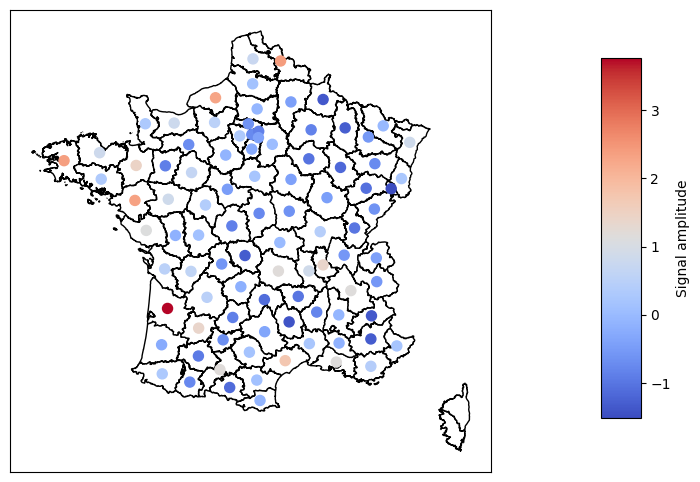

In [110]:
# Test graph contruction
fuel_data.generate_graph()
print(type(fuel_data.graph.nodes[1]['pos']))
plot_graph_department(fuel_data.graph, samples_2005[:, 0])

## Fuel comparisons for an estimated graph across years

num var 12
num dpt 12
num years 17


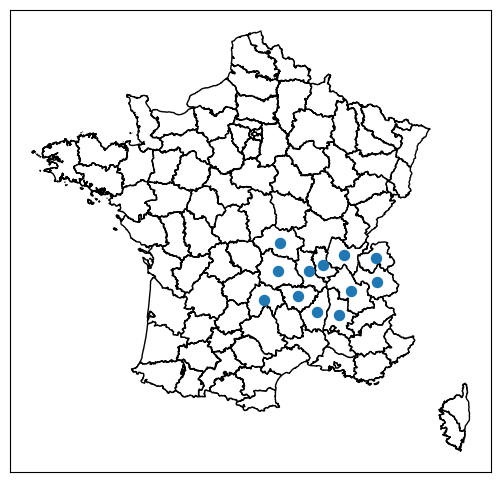

In [126]:
#Load data
region_ARA = [1, 3, 7, 15, 26, 38, 42, 43, 63, 69, 73, 74] #dpt region Auvergne Rhones Alpes
fuel_data_ARA = Fuel_data('../__data/Donnees-annuelles-de-consommation-de-produits-petroliers-par-departement-France-metropol.2022-09.csv')
fuel_data_ARA.truncate(dpt_to_keep=region_ARA)
print("num var", fuel_data_ARA.num_fuel)
print("num dpt", fuel_data_ARA.num_dpt)
print("num years", fuel_data_ARA.num_years)
fuel_data_ARA.generate_graph()
plot_graph_department(fuel_data_ARA.graph)


In [137]:
# Solver
# Solver parameters
max_iter = 1000
alpha = 5e-4
beta = 4e-4
solvers.options['show_progress'] = False
np.random.seed(3)
est_graphs = {}
computed_years = {}
computed_fuels = []
for fuel in fuel_data_ARA.fuel_keys :
    sample, years = fuel_data_ARA.samples_by_year(fuel)
    # Solving only for the fuels with for minimum one year
    if len(years) >= 1 :
        computed_fuels.append(fuel)
        L_est, Y_est = gl_sig_model(sample.T, max_iter, alpha, beta)
        print(f"Fuel {fuel} for {len(years)} years, L_est shape : {L_est.shape}")
        g_est = create_graph_from_laplacian(L_est, list(fuel_data_ARA.graph.nodes))
        for node in g_est.nodes :
            g_est.nodes[node]['pos'] = fuel_data_ARA.graph.nodes[node]['pos']
        est_graphs[fuel] = g_est
        computed_years[fuel] = years

Fuel SUPER_PLOMBE for 3 years, L_est shape : (12, 12)
Fuel SUPER_SANS_PLOMB for 17 years, L_est shape : (12, 12)
Fuel GAZOLE for 17 years, L_est shape : (12, 12)
Fuel FOD for 17 years, L_est shape : (12, 12)
Fuel FOL for 17 years, L_est shape : (12, 12)
Fuel GNR for 11 years, L_est shape : (12, 12)
Fuel GPL for 7 years, L_est shape : (12, 12)
Fuel SUPER_SANS_PLOMB_95 for 14 years, L_est shape : (12, 12)
Fuel SUPER_SANS_PLOMB_95_E10 for 14 years, L_est shape : (12, 12)
Fuel SUPER_SANS_PLOMB_98 for 14 years, L_est shape : (12, 12)
Fuel SUPER_ETH_E85 for 7 years, L_est shape : (12, 12)


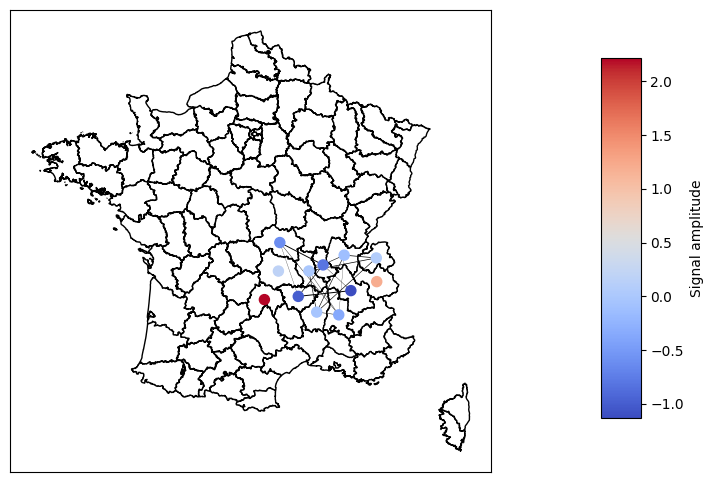

In [138]:
# Print a resulting graph
fuel = SUPER_SANS_PLOMB
plot_graph_department(est_graphs[fuel], node_values=fuel_data_ARA.samples_by_year(fuel)[0][:, 0])

In [140]:
fuels_dist = np.zeros((len(computed_fuels), len(computed_fuels)))
for i, fuel1 in enumerate(computed_fuels) :
    g1 = est_graphs[fuel1]
    for j in range(i+1, len(computed_fuels)) :
        fuel2 = computed_fuels[j]
        g2 = est_graphs[fuel2]
        fuels_dist[i, j] = Fused_Gromov_Wasserstein_distance(alpha=1,features_metric='dirac',method='shortest_path').graph_d(Graph(g1), Graph(g2))



C:\Users\mathi\AppData\Local\Temp\ipykernel_20100\513789147.py:2: RuntimeWarning: divide by zero encountered in log
  plt.matshow(np.log(fuels_dist))


<Figure size 640x480 with 0 Axes>

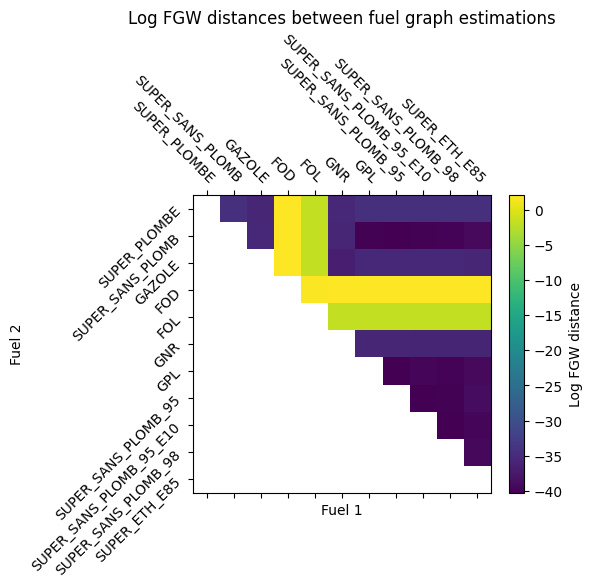

In [155]:
plt.figure()
plt.matshow(np.log(fuels_dist))
plt.xlabel('Fuel 1')
plt.ylabel('Fuel 2')
plt.xticks(np.arange(len(computed_fuels)), computed_fuels, rotation=-45, ha="right", rotation_mode="anchor")
plt.yticks(np.arange(len(computed_fuels)), computed_fuels, rotation=45, ha='right')
plt.title("Log FGW distances between fuel graph estimations")
plt.colorbar(label='Log FGW distance', shrink=0.8)
plt.show()
